In [1]:
!git clone https://github.com/MatthewCWeston/epymarl_continuous
%cd /content/epymarl_continuous

Cloning into 'epymarl_continuous'...
remote: Enumerating objects: 855, done.
remote: Counting objects: 100% (599/599), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 855 (delta 470), reused 405 (delta 398), pack-reused 256 (from 1)
Receiving objects: 100% (855/855), 3.16 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (544/544), done.
/content/epymarl_continuous


### Install requirements

In [2]:
!pip install -qr requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.5/183.5 kB 14.7 MB/s eta 0:00:00


In [ ]:
!pip install -qr env_requirements.txt

## Train a model in a discrete setting

### Run training

In [5]:
%cd /content/epymarl
'''
  batch_size_run: Number of CPUs running agents
  t_max: Total timesteps to train
  save_model: Save the model during training.
  buffer_size, batch_size: size of replay buffer; timesteps to update weights after.
  obs_agent_id: Append a one-hot boolean to the end of the observation
  runner/learner/<> log interval: Rate at which runner/learner/system should log outputs
  target_update_interval_or_tau: Determines hard or soft updates to target weights.
'''
!python src/main.py --config=mappo --env-config=mpe with env_args.key="pz-mpe-simple-v3" env_args.time_limit=25 env_args.max_cycles=25 save_model=True save_model_interval=20000 t_max=20000 batch_size_run=1 buffer_size=100 batch_size=100 obs_agent_id=False runner_log_interval=1000 learner_log_interval=1000 log_interval=1000 use_rnn=False

[Errno 2] No such file or directory: '/content/epymarl'
/content/epymarl_continuous
[DEBUG 07:00:43] git.cmd Popen(['git', 'version'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:00:43] git.cmd Popen(['git', 'version'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:00:43] git.cmd Popen(['git', 'diff', '--cached', '--abbrev=40', '--full-index', '--raw'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:00:43] git.cmd Popen(['git', 'diff', '--abbrev=40', '--full-index', '--raw'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:00:43] git.cmd Popen(['git', 'cat-file', '--batch-check'], cwd=/content/epymarl_continuous, stdin=<valid stream>, shell=False, universal_newlines=False)
[DEBUG 07:00:43] git.cmd Popen(['git', 'diff', '--cached', '--abbrev=40', '--full-index', '--raw'], cwd=/content/epymarl_contin

### Imports

In [15]:
%cd /content/epymarl_continuous
import sys
sys.path.append('/content/epymarl_continuous/src')
import os
import yaml
import copy
import json
from types import SimpleNamespace as SN
from collections.abc import Mapping
import numpy as np
import torch
import matplotlib.pyplot as plt
from runners import REGISTRY as r_REGISTRY
from src.modules.agents.rnn_agent import RNNAgent
from src.components.action_selectors import ContinuousSelector

from PIL import Image, ImageSequence, ImageDraw
import IPython.display
from collections import defaultdict
from pettingzoo.utils.wrappers.base import BaseWrapper

from pettingzoo.mpe import simple_speaker_listener_v4, simple_reference_v3, simple_world_comm_v3, simple_v3

/content/epymarl_continuous


### View Training Results

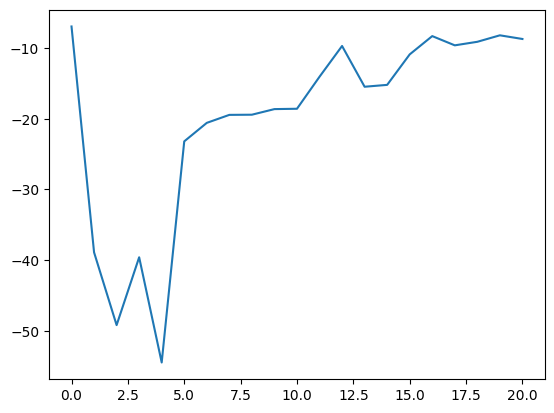

In [7]:
# @title Display reward over time
env_name = 'pz-mpe-simple-v3'
alg_name = 'mappo'

results_path = '/content/epymarl_continuous/results'
sacred_path  = f'{results_path}/sacred/{alg_name}/pz-mpe-simple-v3'
results_dir = max([os.path.join(sacred_path, d) for d in os.listdir(sacred_path)], key=os.path.getmtime).split('/')[-1]
models_path = f'{results_path}/models'
models_path = max([os.path.join(models_path, d) for d in os.listdir(models_path)], key=os.path.getmtime) # Newest run
models_path = max([os.path.join(models_path, d) for d in os.listdir(models_path)], key=os.path.getmtime) # Last update
with open(f'{sacred_path}/{results_dir}/metrics.json', 'r') as f:
  metrics = json.load(f)
metrics.keys()
plt.plot(metrics['return_mean']['values'])

In [8]:
# @title Look up env data
# Get config dicts
cfg_path = '/content/epymarl_continuous/src/config'
alg_name = 'mappo'

def recursive_dict_update(d, u):
    for k, v in u.items():
        if isinstance(v, Mapping):
            d[k] = recursive_dict_update(d.get(k, {}), v)
        else:
            d[k] = v
    return d
with open(os.path.join(cfg_path,"default.yaml",),"r",) as f:
  cfg_dict = yaml.load(f, Loader=yaml.FullLoader)
with open(os.path.join(cfg_path,"envs","mpe.yaml",),"r",) as f:
  env_dict = yaml.load(f, Loader=yaml.FullLoader)
with open(os.path.join(cfg_path,"algs",f"{alg_name}.yaml",),"r",) as f:
  alg_dict = yaml.load(f, Loader=yaml.FullLoader)
config_dict = recursive_dict_update(cfg_dict, env_dict)
config_dict = recursive_dict_update(cfg_dict, alg_dict)
#
config_dict["env_args"]["seed"] = 0
config_dict["env_args"]["key"] = env_name
config_dict["env_args"]["time_limit"]=25
#
args = SN(**config_dict)
args.device = "cpu"
args.unique_token = 'TESTTESTTEST'
#
runner = r_REGISTRY[args.runner](args=args,logger=None) # Some algs () use parallel. batch_size_run increases parallelism. ippo, coma, ia2c, maa2c, mappo
env_info = runner.get_env_info()
args.n_agents = env_info["n_agents"]
args.n_actions = env_info["n_actions"]
args.state_shape = env_info["state_shape"]

!!! USING MPE ENVIRONMENT


<ipython-input-9-2bd04f1dd12d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(f'{models_path}/agent.th', map_location=lambda storage, loc:

defaultdict(<function <lambda> at 0x7b2c45fd7a60>, {'agent_0': -11.212522623872562})


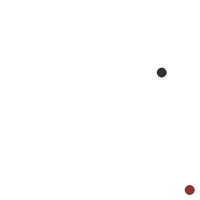

In [9]:
# @title Display a sample run
args.use_rnn = False # Since the default is 'true' for MAPPO but not MAPPO_NS
agent = RNNAgent(env_info['obs_shape'], args)
agent.load_state_dict(torch.load(f'{models_path}/agent.th', map_location=lambda storage, loc: storage))
env_cfg = {'max_cycles': 75}
target_env = {
  "pz-mpe-simple-speaker-listener-v4": simple_speaker_listener_v4,
  "pz-mpe-simple-reference-v3": simple_reference_v3,
  "pz-mpe-simple-world-comm-v3": simple_world_comm_v3,
  "pz-mpe-simple-v3": simple_v3,
}[env_name]
env = target_env.env(**env_cfg)
while isinstance(env, BaseWrapper): # Discard all wrappers
    env = env.env
env.reset()
try:
  env.env.render_mode = 'rgb_array' # We want a video of what our agent is doing.
except Exception:
  env.render_mode = 'rgb_array' # For e.g. Pettingzoo, with no base env below.
agent_ids = {agent: torch.nn.functional.one_hot(torch.tensor(i), num_classes=len(env.agents)) for i, agent in enumerate(env.agents)}
env.reset()
rewards = defaultdict(lambda: 0)
random_act = False
images = []

# We have one agent, so pad the observation with zeros and add a one-hot to the end.
def act(a, obs):
  #obs = np.pad(obs, (0, env_info['obs_shape'] + len(env.agents) - len(obs)))
  #obs[-len(env.agents):] = agent_ids[a]
  n = env.action_space(a).n
  action_logits, _ = agent(torch.tensor(obs), torch.tensor([]))
  return action_logits[:n].argmax().numpy()

while (True):
  selected_agent = env.agent_selection
  if (env.terminations[selected_agent] or env.truncations[selected_agent]):
    break # Terminated or truncated.
  obs = env.observe(selected_agent)
  if (random_act): # Something to compare against, as a baseline.
    action = env.action_space(selected_agent).sample()
  else:
    action = act(selected_agent, obs)
  env.step(action)
  rewards[selected_agent] += env.rewards[selected_agent]
  images.append(env.render())
print(rewards)
# Display the video. Takes a few minutes with large images.
new_size = 200
gif_list = [Image.fromarray(x).resize((new_size,new_size)) for x in images]
gif_list[0].save("./test.gif", save_all=True, append_images=gif_list[1:])
IPython.display.Image(filename='./test.gif')

## Train a model in a continuous setting

In [10]:
!python src/main.py --config=mappo_c --env-config=mpe_continuous with env_args.key="pz-mpe-simple-v3" env_args.time_limit=25 env_args.max_cycles=25 save_model=True save_model_interval=20000 t_max=20000 batch_size_run=1 buffer_size=100 batch_size=100 obs_agent_id=False runner_log_interval=1000 learner_log_interval=1000 log_interval=1000 use_rnn=False

[DEBUG 07:05:09] git.cmd Popen(['git', 'version'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:05:09] git.cmd Popen(['git', 'version'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:05:09] git.cmd Popen(['git', 'diff', '--cached', '--abbrev=40', '--full-index', '--raw'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:05:09] git.cmd Popen(['git', 'diff', '--abbrev=40', '--full-index', '--raw'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:05:09] git.cmd Popen(['git', 'cat-file', '--batch-check'], cwd=/content/epymarl_continuous, stdin=<valid stream>, shell=False, universal_newlines=False)
[DEBUG 07:05:09] git.cmd Popen(['git', 'diff', '--cached', '--abbrev=40', '--full-index', '--raw'], cwd=/content/epymarl_continuous, stdin=None, shell=False, universal_newlines=False)
[DEBUG 07:05:09] git.cmd Po

### View training results

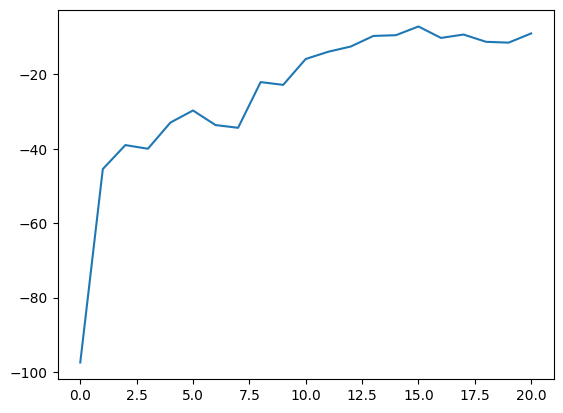

In [11]:
# @title Display reward over time
env_name = 'pz-mpe-simple-v3'
alg_name = 'mappo_c'

results_path = '/content/epymarl_continuous/results'
sacred_path  = f'{results_path}/sacred/{alg_name}/pz-mpe-simple-v3'
results_dir = max([os.path.join(sacred_path, d) for d in os.listdir(sacred_path)], key=os.path.getmtime).split('/')[-1]

models_path = f'{results_path}/models'
models_path = max([os.path.join(models_path, d) for d in os.listdir(models_path)], key=os.path.getmtime) # Newest run
models_path = max([os.path.join(models_path, d) for d in os.listdir(models_path)], key=os.path.getmtime) # Last update

with open(f'{sacred_path}/{results_dir}/metrics.json', 'r') as f:
  metrics = json.load(f)
metrics.keys()
plt.plot(metrics['return_mean']['values'])

In [13]:
# @title Look up env data
# Get config dicts
cfg_path = '/content/epymarl_continuous/src/config'
alg_name = 'mappo'

def recursive_dict_update(d, u):
    for k, v in u.items():
        if isinstance(v, Mapping):
            d[k] = recursive_dict_update(d.get(k, {}), v)
        else:
            d[k] = v
    return d
with open(os.path.join(cfg_path,"default.yaml",),"r",) as f:
  cfg_dict = yaml.load(f, Loader=yaml.FullLoader)
with open(os.path.join(cfg_path,"envs","mpe.yaml",),"r",) as f:
  env_dict = yaml.load(f, Loader=yaml.FullLoader)
with open(os.path.join(cfg_path,"algs",f"{alg_name}.yaml",),"r",) as f:
  alg_dict = yaml.load(f, Loader=yaml.FullLoader)
config_dict = recursive_dict_update(cfg_dict, env_dict)
config_dict = recursive_dict_update(cfg_dict, alg_dict)
#
config_dict["env_args"]["seed"] = 0
config_dict["env_args"]["key"] = env_name
config_dict["env_args"]["time_limit"]=25
#
args = SN(**config_dict)
args.device = "cpu"
args.unique_token = 'TESTTESTTEST'
#
runner = r_REGISTRY[args.runner](args=args,logger=None) # Some algs () use parallel. batch_size_run increases parallelism. ippo, coma, ia2c, maa2c, mappo
env_info = runner.get_env_info()
args.n_agents = env_info["n_agents"]
args.n_actions = env_info["n_actions"]
args.state_shape = env_info["state_shape"]

!!! USING MPE ENVIRONMENT


<ipython-input-16-4eae6380a26b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(f'{models_path}/agent.th', map_location=lambda storage, loc

defaultdict(<function <lambda> at 0x7b2c3b28e200>, {'agent_0': -15.912209230865944})


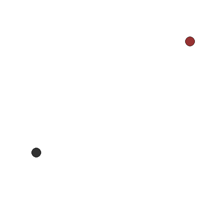

In [16]:
# @title Display a sample run
args_temp = copy.copy(args)
args_temp.use_rnn = False # Since the default is apparently 'true' for MAPPO but not MAPPO_NS
args_temp.n_actions *= 2
agent = RNNAgent(env_info['obs_shape'], args_temp)
agent.load_state_dict(torch.load(f'{models_path}/agent.th', map_location=lambda storage, loc: storage))
selector = ContinuousSelector(args_temp)

env_cfg = {'max_cycles': 75, 'continuous_actions': True}
target_env = simple_v3

env = target_env.env(**env_cfg)
while isinstance(env, BaseWrapper): # Discard all wrappers
    env = env.env
env.reset()
try:
  env.env.render_mode = 'rgb_array' # We want a video of what our agent is doing.
except Exception:
  env.render_mode = 'rgb_array' # For e.g. Pettingzoo, with no base env below.

env.reset()
rewards = defaultdict(lambda: 0)
random_act = False
images = []

# We have one agent, so pad the observation with zeros and add a one-hot to the end.
def act(a, obs, selector):
  #obs = np.pad(obs, (0, env_info['obs_shape'] + len(env.agents) - len(obs)))
  #obs[-len(env.agents):] = agent_ids[a]
  agent_out, _ = agent(torch.tensor(obs), torch.tensor([]))
  agent_out = agent_out.unsqueeze(0).unsqueeze(0)
  action =  selector.select_action(agent_out, None, None)
  return action.squeeze()

while (True):
  selected_agent = env.agent_selection
  if (env.terminations[selected_agent] or env.truncations[selected_agent]):
    break # Terminated or truncated.
  obs = env.observe(selected_agent)
  if (random_act): # Something to compare against, as a baseline.
    action = env.action_space(selected_agent).sample()
  else:
    action = act(selected_agent, obs, selector)
  env.step(action)
  rewards[selected_agent] += env.rewards[selected_agent]
  images.append(env.render())
print(rewards)

# Display the video. Takes a few minutes with large images.
new_size = 200
gif_list = [Image.fromarray(x).resize((new_size,new_size)) for x in images]
gif_list[0].save("./test.gif", save_all=True, append_images=gif_list[1:])
IPython.display.Image(filename='./test.gif')